<a href="https://colab.research.google.com/github/yeesem/Advanced-Tensorflow-Specialization/blob/main/Class_Activation_Map_CatsDogsDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [7]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

# Download and Prepare the Dataset

In [2]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs',split = 'train[-10%:]',as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteGS2V6V/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
def augment_data(image,label):
   # Cast to float
   image = tf.cast(image,tf.float32)

   # Normalize the pixel values
   image = image/255.0

   # Resize to 300x300
   image = tf.image.resize(image,(300,300))

   return image,label

# Use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_data)

# Shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

# Build the classifier

In [4]:
model = Sequential()
model.add(Conv2D(16,input_shape = (300,300,3),kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

In [8]:
plot_model(model,show_shape = True,show_layer_names = True)

TypeError: plot_model() got an unexpected keyword argument 'show_shape'

In [5]:
model.compile(
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    optimizer = tf.keras.optimizers.RMSprop(lr = 0.001)
)

model.fit(train_batches,epochs = 25)

Epoch 1/25
582/582 [==============================] - 69s 102ms/step - loss: 0.6576 - accuracy: 0.5954
Epoch 2/25
582/582 [==============================] - 47s 76ms/step - loss: 0.6256 - accuracy: 0.6404
Epoch 3/25
582/582 [==============================] - 52s 87ms/step - loss: 0.6064 - accuracy: 0.6673
Epoch 4/25
582/582 [==============================] - 62s 104ms/step - loss: 0.5951 - accuracy: 0.6762
Epoch 5/25
582/582 [==============================] - 67s 108ms/step - loss: 0.5815 - accuracy: 0.6947
Epoch 6/25
582/582 [==============================] - 46s 75ms/step - loss: 0.5748 - accuracy: 0.6989
Epoch 7/25
582/582 [==============================] - 53s 86ms/step - loss: 0.5654 - accuracy: 0.7078
Epoch 8/25
582/582 [==============================] - 63s 103ms/step - loss: 0.5582 - accuracy: 0.7141
Epoch 9/25
582/582 [==============================] - 60s 98ms/step - loss: 0.5479 - accuracy: 0.7260
Epoch 10/25
582/582 [==============================] - 56s 94ms/step - loss: 0

# Build the Class Activation Map Model

In [6]:
# 0 - weights,1 - bias
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model = Model(inputs = model.input,
                  outputs = (model.layers[-3].output,model.layers[-1].output)
                  )
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

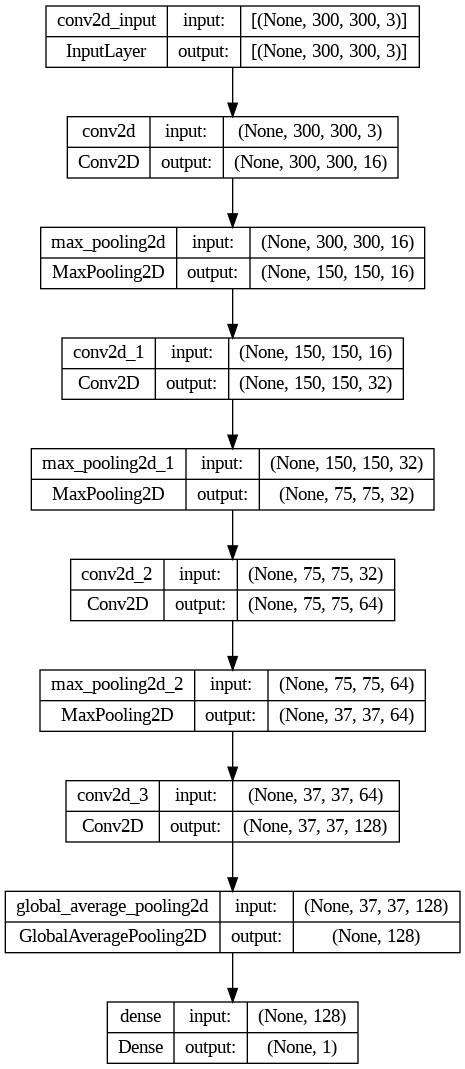

In [10]:
plot_model(cam_model,show_shapes = True,show_layer_names = True)

In [18]:
def show_cam(image_value,features,results):
  # There is only one image in the batch so index == '0'
  features_for_img = features[0]
  prediction = results[0]

  # There is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # Upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img,(300/37,300/37,1),order = 2)

  # Compute the intensity of each features in the CAM
  cam_output = np.dot(class_activation_features,
                      class_activation_weights)

  # Visualize the results
  print("Sigmoid output : ",results)
  print(f"Prediction : {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize = (8,8))
  plt.imshow(cam_output,cmap = 'jet',alpha = 0.5)
  plt.imshow(tf.squeeze(image_value),alpha = 0.5)
  plt.show()

# Testing the Model

In [12]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

--2024-05-31 08:33:14--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K   515KB/s    in 0.8s    

2024-05-31 08:33:15 (515 KB/s) - ‘cat1.jpg’ saved [414826/414826]

--2024-05-31 08:33:15--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Saving to: 

1/1 [==============================] - 0s 70ms/step
sigmoid output: [[0.10977906]]
prediction: cat


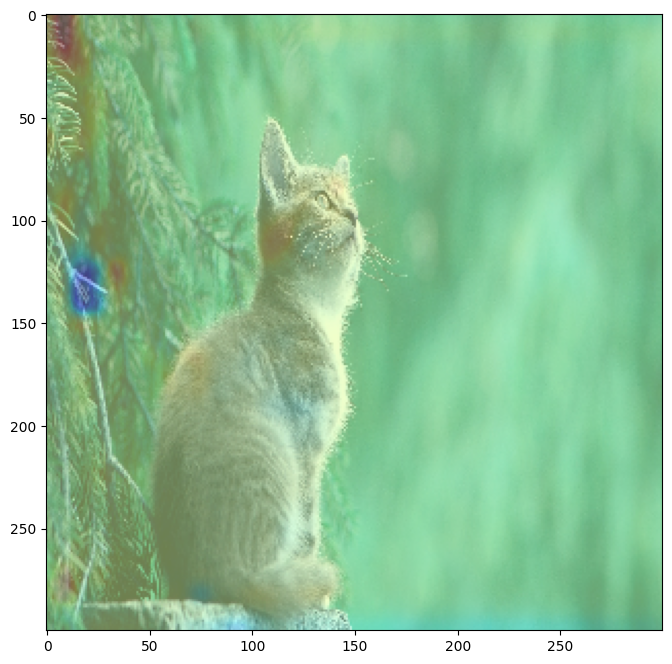

1/1 [==============================] - 0s 23ms/step
sigmoid output: [[0.26172638]]
prediction: cat


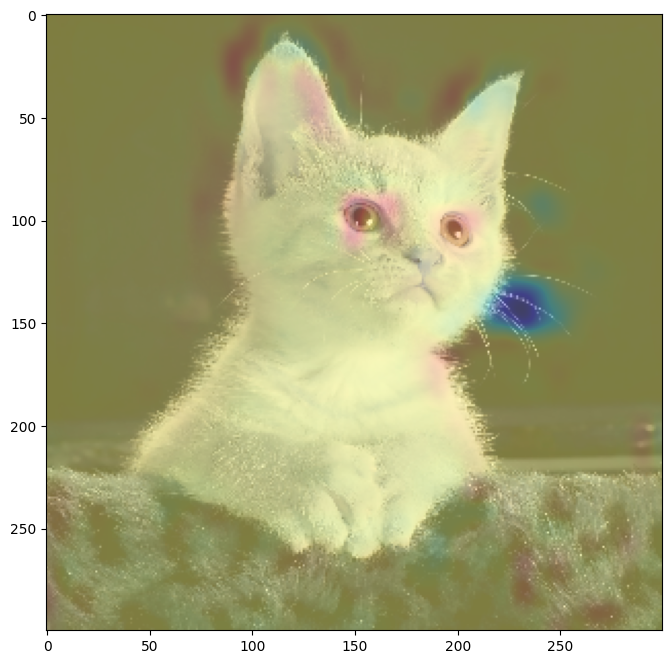

1/1 [==============================] - 0s 17ms/step
sigmoid output: [[0.6345842]]
prediction: dog


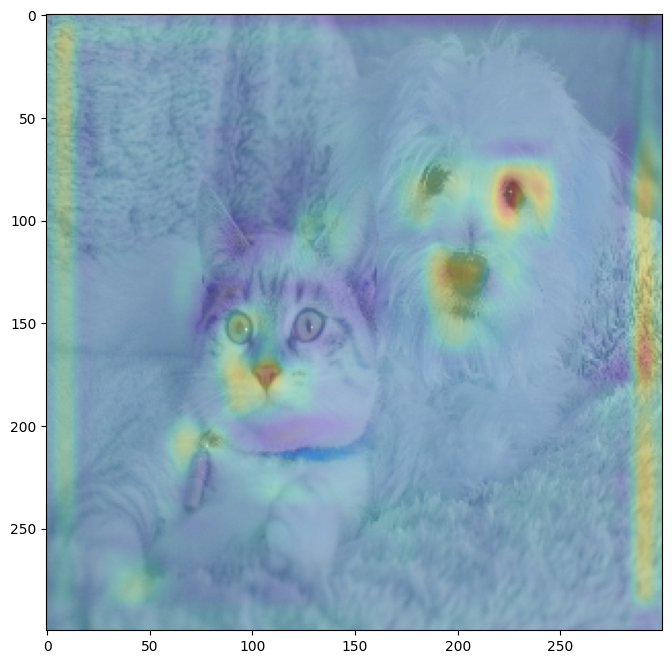

1/1 [==============================] - 0s 21ms/step
sigmoid output: [[0.36107156]]
prediction: cat


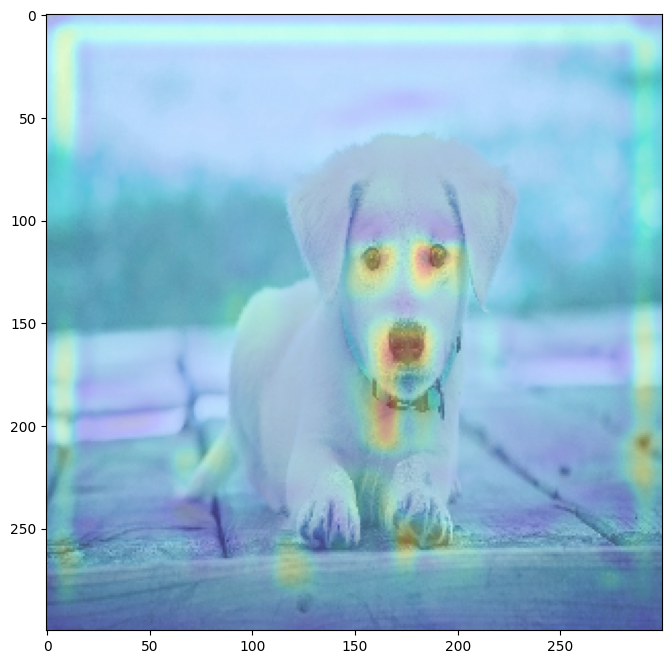

1/1 [==============================] - 0s 32ms/step
sigmoid output: [[0.6118501]]
prediction: dog


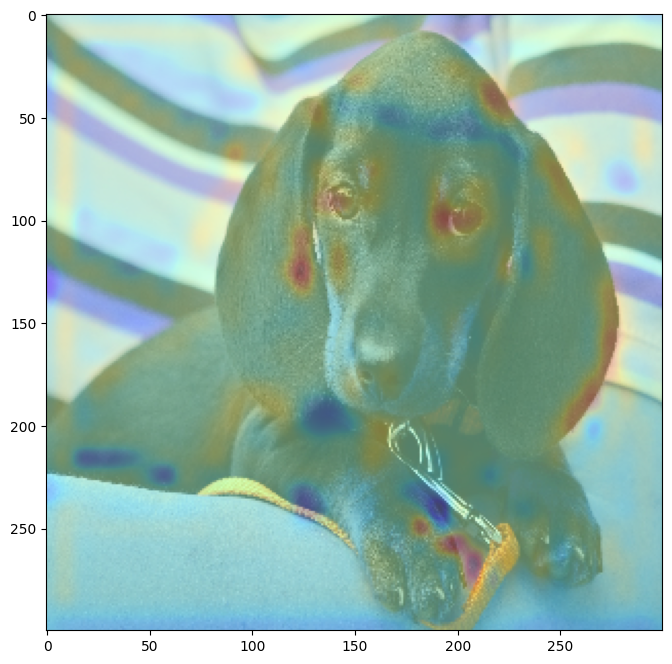

In [19]:
def convert_and_classify(image):
   # Load the image
   img = cv2.imread(image)

   # Preprocess the image before feeding it to the model
   img = cv2.resize(img,(300,300))/255.0

   # Add a batch dimension because the model expects it
   tensor_image = np.expand_dims(img,axis = 0)

   # Get the features and the predictions
   features,results = cam_model.predict(tensor_image)

   # Generate CAM
   show_cam(tensor_image,features,results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

Ground truth : cat
1/1 [==============================] - 0s 18ms/step
sigmoid output: [[0.34409693]]
prediction: cat


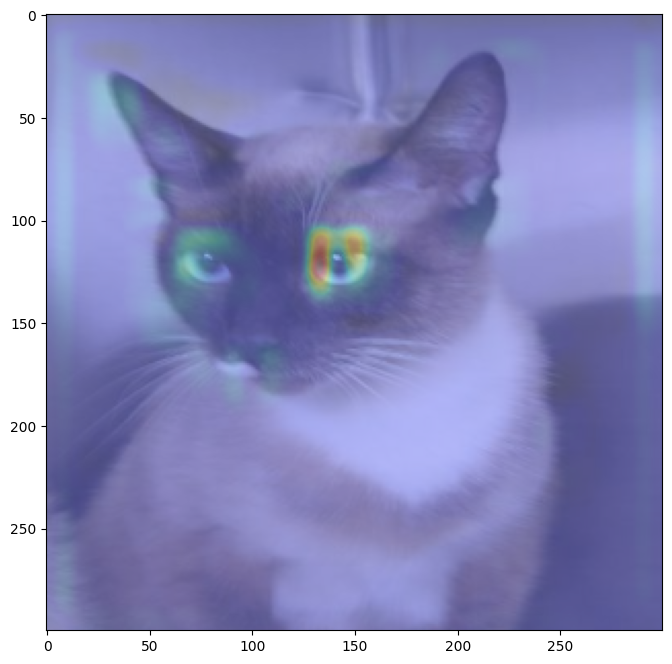

Ground truth : dog
1/1 [==============================] - 0s 20ms/step
sigmoid output: [[0.10127202]]
prediction: cat


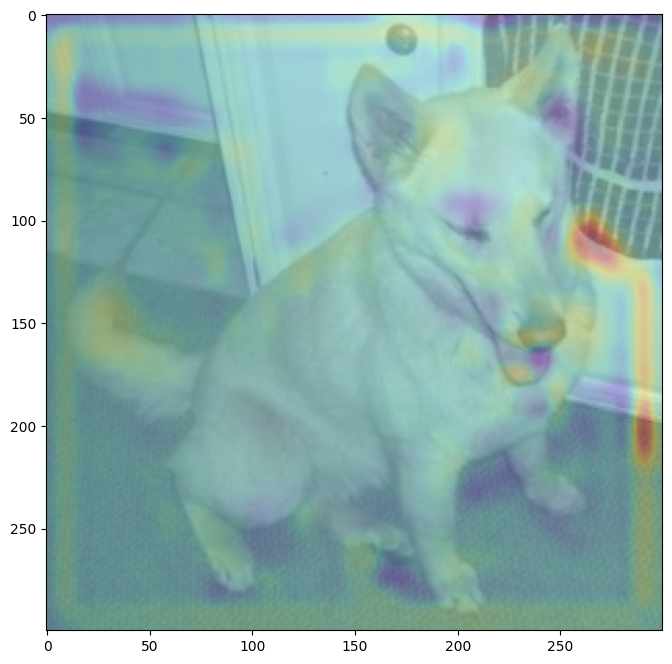

Ground truth : dog
1/1 [==============================] - 0s 31ms/step
sigmoid output: [[0.1509508]]
prediction: cat


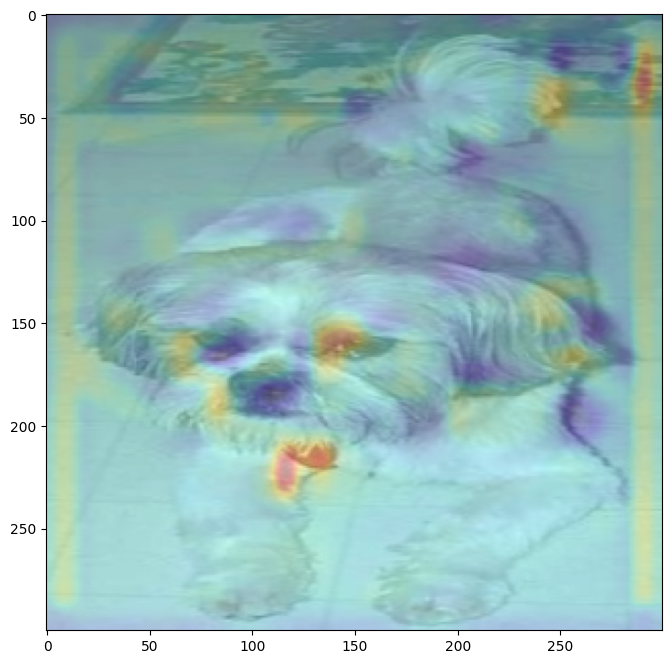

Ground truth : cat
1/1 [==============================] - 0s 39ms/step
sigmoid output: [[0.03861132]]
prediction: cat


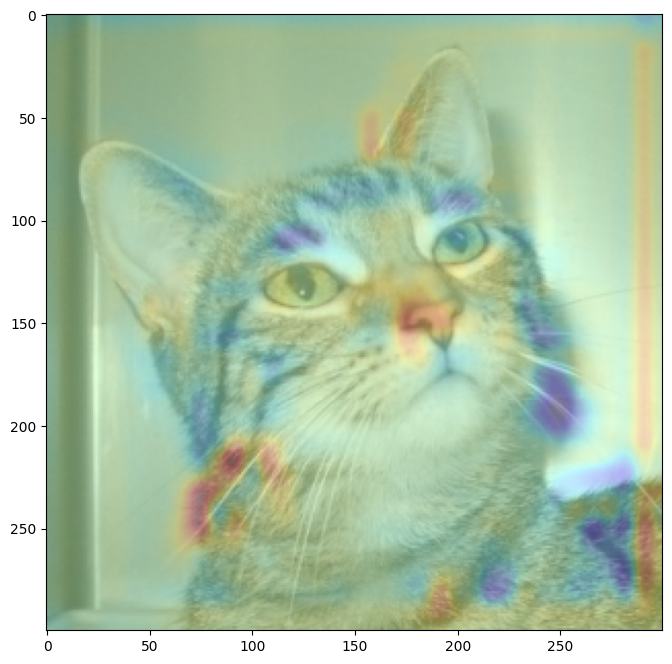

Ground truth : cat
1/1 [==============================] - 0s 24ms/step
sigmoid output: [[0.2289171]]
prediction: cat


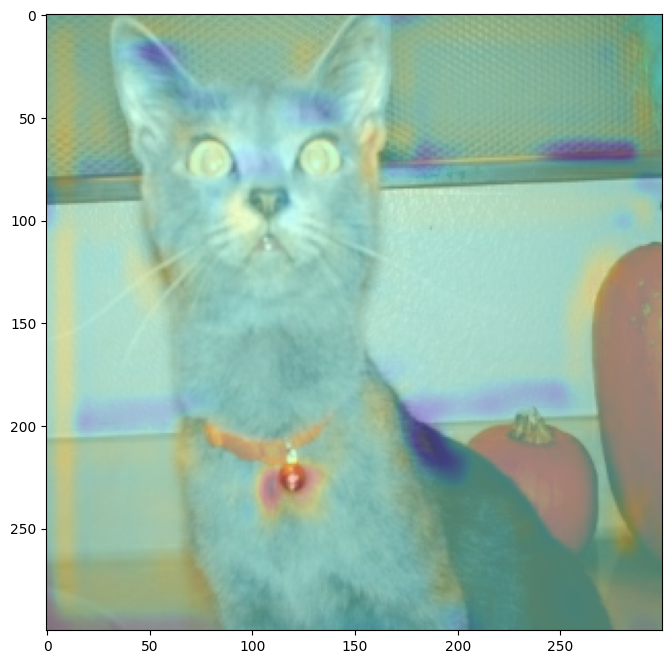

In [20]:
# Preprocess the test images
augmented_test_data = test_data.map(augment_data)
test_batches = augmented_test_data.batch(1)

for img,lbl in test_batches.take(5):
  print(f"Ground truth : {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img,features,results)